In [14]:
# This is only for development purposes

import sys
import memento
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import memento
from sklearn.preprocessing import LabelEncoder

In [9]:
file = '/data2st1/junyi/output/atac0416/3REGIONS_peak.h5ads'
region = 'AMY'
adata_all = sc.read_h5ad(file)
adata_all = adata_all[(adata_all.obs['sample'].str.contains(region))]
adata = adata_all[adata_all.obs['region_nt']=='AMY_Glut'].copy()

In [10]:
adata

AnnData object with n_obs × n_vars = 23759 × 1371000
    obs: 'sample', 'leiden', 'celltype.L2', 'leiden_tile', 'celltype.L1', 'region', 'Neurotransmitter_celltype', 'region_nt', 'celltype.L3', 'celltype.L4', 'expriment'
    uns: 'log1p'
    obsm: 'X_spectral', 'X_umap'
    layers: 'count'

In [11]:
adata.obs['stim'] = adata.obs['expriment'].apply(lambda x: 0 if x == 'MW' else 1)


In [ ]:
le = LabelEncoder()
le.fit(adata.obs['sample'])
adata.obs['ind'] = le.transform(adata.obs['sample'])

LabelEncoder()

In [48]:
adata.X.sum(axis=1)

matrix([[15661],
        [ 4580],
        [ 2593],
        ...,
        [ 2625],
        [ 4783],
        [12454]], dtype=uint64)

In [18]:
adata.obs[['ind','stim', 'region_nt']].sample(10)


,ind,stim,region_nt
MC52E_AMY:TACAGCATCGAGGCTC-1,2,1,AMY_Glut
MW47A_AMY:TGCTTTATCAGCCGAC-1,3,0,AMY_Glut
MC50B_AMY:TACTAGGTCGATTACG-1,1,1,AMY_Glut
MW47A_AMY:AACGAGGAGAACGTCG-1,3,0,AMY_Glut
MC50B_AMY:GCACCTTTCCGTCAAA-1,1,1,AMY_Glut
MW51A_AMY:CTCACCATCCAACGCG-1,4,0,AMY_Glut
MW47A_AMY:CACCTTGGTGTCCTTC-1,3,0,AMY_Glut
MC52E_AMY:AACTTGGTCCTGAAAC-1,2,1,AMY_Glut
MC50B_AMY:GTACTTTAGTACCTCA-1,1,1,AMY_Glut
MC52E_AMY:ACGTTAGCATGATCGT-1,2,1,AMY_Glut


In [5]:
from scipy.sparse.csr import csr_matrix
type(adata.X) == csr_matrix


/tmp/ipykernel_2472504/3982948649.py:1: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.sparse.csr import csr_matrix


True

In [ ]:
adata.layers['normalized'] = adata.X.copy()
adata.X =adata.layers['count']
result_1d = memento.binary_test_1d(
    adata=adata, 
    capture_rate=0.07, 
    treatment_col='stim', 
    num_cpus=12,
    num_boot=5000)


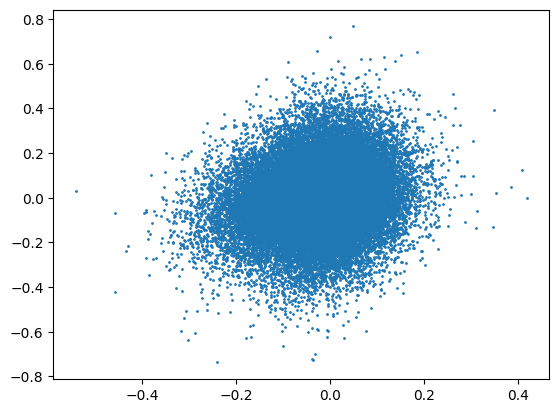

In [26]:
plt.scatter(result_1d.de_coef, result_1d.dv_coef, s=1)


In [30]:
type(result_1d)

pandas.core.frame.DataFrame

In [51]:
result_1d.query('de_coef > 0 & de_pval<0.05').sort_values('de_pval').head(10)


,gene,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval
42142,chrY:90808579-90809080,stim,0.408018,0.028638,5.776331e-46,0.125957,0.103158,0.207744
11644,chr13:119488180-119488681,stim,0.418890,0.032630,1.945333e-37,-0.001632,0.099946,0.913558
14272,chr15:79243166-79243667,stim,0.221774,0.020941,2.273145e-26,-0.024659,0.087971,0.841101
34652,chr7:44869678-44870179,stim,0.159884,0.015825,9.276261e-24,0.018988,0.070724,0.833777
36271,chr7:127745227-127745728,stim,0.189732,0.019111,4.545682e-23,-0.035723,0.077454,0.551612
6692,chr11:87443278-87443779,stim,0.354249,0.037575,5.140446e-21,0.022019,0.134287,0.899627
1461,chr1:131527503-131528004,stim,0.137950,0.014792,8.053991e-21,-0.168753,0.074618,0.028523
31059,chr5:135962460-135962961,stim,0.156804,0.016825,1.075218e-20,0.120953,0.069451,0.065448
34664,chr7:44986338-44986839,stim,0.143998,0.015399,1.196315e-20,-0.117604,0.076093,0.117422
21668,chr2:33130916-33131417,stim,0.152748,0.017079,3.249025e-19,0.028515,0.073368,0.707299


In [31]:
adata.obs['capture_rate'] = 0.07
memento.setup_memento(adata, q_column='capture_rate')
memento.create_groups(adata, label_columns=['stim', 'ind'])
memento.compute_1d_moments(adata,
    min_perc_group=.9) # percentage of groups that satisfy the condition for a gene to be considered. 


In [32]:
sample_meta = memento.get_groups(adata)
sample_meta['ind'] = sample_meta['ind'].astype('category') # make sure to not confuse ourselves in case replicate labels are numbers
sample_meta.head(3)


,stim,ind
sg^1^0,1,0
sg^1^1,1,1
sg^1^2,1,2


In [33]:
treatment_df = sample_meta[['stim']]
treatment_df.head(5)


,stim
sg^1^0,1
sg^1^1,1
sg^1^2,1
sg^0^3,0
sg^0^4,0


In [34]:
cov_df = pd.get_dummies(sample_meta['ind'].astype('category'))
cov_df.head(3)


,0,1,2,3,4
sg^1^0,True,False,False,False,False
sg^1^1,False,True,False,False,False
sg^1^2,False,False,True,False,False


In [35]:
memento.ht_1d_moments(
    adata, 
    treatment=treatment_df,
    covariate=cov_df,
    num_boot=5000, 
    verbose=1,
    num_cpus=40)


[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:   47.5s
[Parallel(n_jobs=40)]: Done 370 tasks      | elapsed:   51.2s
[Parallel(n_jobs=40)]: Done 720 tasks      | elapsed:   56.5s
[Parallel(n_jobs=40)]: Done 1170 tasks      | elapsed:  1.0min
[Parallel(n_jobs=40)]: Done 1720 tasks      | elapsed:  1.2min
[Parallel(n_jobs=40)]: Done 2370 tasks      | elapsed:  1.3min
[Parallel(n_jobs=40)]: Done 3120 tasks      | elapsed:  1.5min
[Parallel(n_jobs=40)]: Done 3970 tasks      | elapsed:  1.7min
[Parallel(n_jobs=40)]: Done 4920 tasks      | elapsed:  1.9min
[Parallel(n_jobs=40)]: Done 5970 tasks      | elapsed:  2.2min
[Parallel(n_jobs=40)]: Done 7120 tasks      | elapsed:  2.5min
[Parallel(n_jobs=40)]: Done 8370 tasks      | elapsed:  2.8min
[Parallel(n_jobs=40)]: Done 9720 tasks      | elapsed:  3.1min
[Parallel(n_jobs=40)]: Done 11170 tasks      | elapsed:  3.4min
[Parallel(n_jobs=40)]: Done 12720 tasks    

In [37]:
result_1d_ht = memento.get_1d_ht_result(adata)


In [44]:
result_1d_ht.sort_values('dv_pval')


,gene,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval
11079,chr15:64177913-64178414,stim,-0.003240,0.107496,1.0,-0.386424,0.304987,0.102768
15658,chr18:74910820-74911321,stim,0.000000,0.000000,NaN,0.252941,0.210097,0.114482
1910,chr1:180037402-180037903,stim,0.001138,0.108133,1.0,0.337585,0.282805,0.116774
23300,chr5:30982359-30982860,stim,0.000000,0.000000,NaN,0.256012,0.215507,0.117868
30932,chr8:119558587-119559088,stim,0.000000,0.000000,NaN,0.339157,0.279627,0.119104
...,...,...,...,...,...,...,...,...
8283,chr13:36019243-36019744,stim,-0.001246,0.053172,1.0,0.016489,0.274929,1.000000
12580,chr16:22491696-22492197,stim,-0.002425,0.064921,1.0,0.112643,0.277141,1.000000
25477,chr6:30693596-30694097,stim,0.000000,0.000000,NaN,-0.006140,0.132097,1.000000
12622,chr16:27523708-27524209,stim,-0.003191,0.548670,1.0,-0.032707,0.136914,1.000000
